In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [2]:
PATH_TO_DATA = 'data/input/raw/'
SEED = 17

In [3]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [4]:
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

In [5]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 50000) (82797, 50000)


In [6]:
vectorizer.get_feature_names()[:10]

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

In [7]:
vectorizer.get_feature_names()[10000:10010]

['de-img3.ask.fm',
 'de-img4.ask.fm',
 'de.tynt.com',
 'de.tynt.com api.adyoulike.com',
 'de.tynt.com api.adyoulike.com syndication.twitter.com',
 'de.tynt.com api.adyoulike.com twitter.com',
 'de.tynt.com platform.twitter.com',
 'de.tynt.com platform.twitter.com twitter.com',
 'de.tynt.com premium.hi-mediaserver.com',
 'de.tynt.com syndication.twitter.com']

In [8]:
time_split = TimeSeriesSplit(n_splits=10)

In [9]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [10]:
cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

In [11]:
cv_scores1, cv_scores1.mean()

(array([0.83124023, 0.65993466, 0.85673565, 0.92824237, 0.84779639,
        0.88954524, 0.88829128, 0.87710523, 0.92023038, 0.92624125]),
 0.8625362694151277)

In [12]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

In [13]:
eli5.show_weights(estimator=logit, 
                  feature_names=vectorizer.get_feature_names(), top=30)

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [14]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv("data/output/2/" + out_file, index_label=index_label)

In [15]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv') # 0.91807

In [16]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train, 
                  X_test=X_test_sites, site_feature_names=vectorizer.get_feature_names(),              
                  cv=time_split, submission_file_name='subm1.csv')

CV scores [0.83124023 0.65993466 0.85673565 0.92824237 0.84779639 0.88954524
 0.88829128 0.87710535 0.92023038 0.92624209]
CV mean: 0.8625363644145931, CV std: 0.07455679771627693


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [18]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

/home/Aleksandr/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


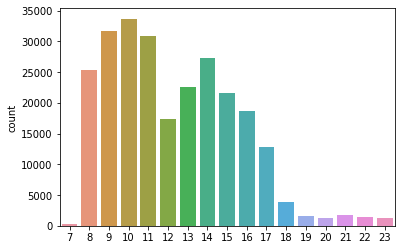

In [19]:
sns.countplot(session_start_hour);

/home/Aleksandr/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/Aleksandr/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


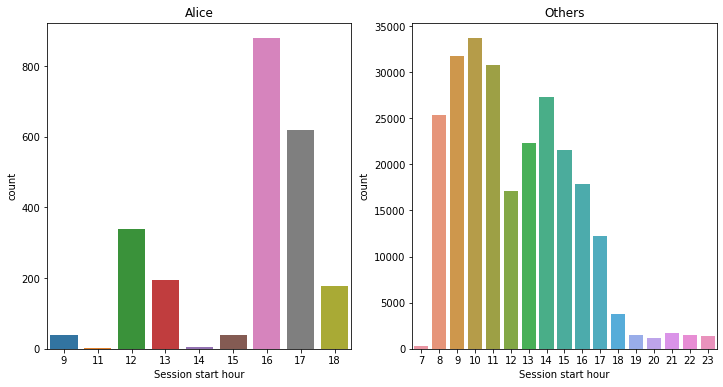

In [20]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

In [21]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [22]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

In [23]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [24]:
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

In [25]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50005), (82797, 50005))

In [26]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CV scores [0.81904687 0.78705941 0.94510729 0.96677305 0.88993687 0.96695898
 0.91829701 0.93962258 0.96595914 0.96884529]
CV mean: 0.9167606489276225, CV std: 0.06210707225234801


Weight?,Feature
+7.046,hour
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.987,www.express.co.uk
+4.833,youwatch.org
+4.803,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


New feature weights:
   feature      coef
0  morning -2.904810
1      day -0.613784
2  evening -5.069841
3    night  0.000000
4     hour  7.045559


In [27]:
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [28]:
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)


cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                               X_test=X_test_with_times2, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm3.csv')

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CV scores [0.88170019 0.81426901 0.91861327 0.96171465 0.91532998 0.95227476
 0.92804771 0.94016178 0.94665449 0.95277436]
CV mean: 0.9211540194603813, CV std: 0.04206422158202137


Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
   feature      coef
0  morning -3.211819
1      day  0.526636
2  evening -2.721465
3    night  0.000000


In [29]:
def add_session_duration_incorrect(times, X_sparse):
    new_feat = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    return hstack([X_sparse, new_feat.values.reshape(-1, 1)])

In [30]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

In [31]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train, 
                               X_test=X_test_with_time_incorrect, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm4.csv')

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CV scores [0.57324417 0.6057354  0.59064502 0.55137641 0.63484782 0.66004053
 0.74572105 0.67174803 0.61461151 0.61200149]
CV mean: 0.6259971432088414, CV std: 0.05291615658123371


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 
 … 1784 more positive … 
 
 
 

 
 
 
 … 48191 more negative … 
 
 
 
 
 
 
 -0.009
 
 
 khms1.google.fr
 
 
 
 
 
 
 -0.009
 
 
 ts2.mm.bing.net
 
 
 
 
 
 
 -0.010
 
 
 s.ytimg.com
 
 
 
 
 
 
 -0.010
 
 
 www.youtube.com
 
 
 
 
 
 
 -0.010
 
 
 mail.google.com
 
 
 
 
 
 
 -0.011
 
 
 clients1.google.com
 
 
 
 
 
 
 -0.012
 
 
 mts1.google.com
 
 
 
 
 
 
 -0.012
 
 
 ajax.googleapis.com
 
 
 
 
 
 
 -0.012
 
 
 twitter.com
 
 
 
 
 
 
 -0.012
 
 
 mts0.google.com
 
 
 
 
 
 
 -0.014
 
 
 accounts.google.com
 
 
 
 
 
 
 -0.015
 
 
 ts1.mm.bing.net
 
 
 
 
 
 
 -0.015
 
 
 connect.facebook.net
 
 
 
 
 
 
 -0.019
 
 
 www.google.fr
 
 
 
 
 
 
 -0.021
 
 
 s-static.ak.facebook.com
 
 
 
 
 
 
 -0.022
 
 
 static.ak.facebook.com
 
 
 
 
 
 
 -0.023
 
 
 www.bing.com
 
 
 
 
 
 
 -0.024
 
 
 apis.google.com
 
 
 
 
 
 
 -0.025
 
 
 www.google.com
 
 
 
 
 
 
 -0.026
 
 
 platform.twitter.com
 
 
 
 
 
 
 -0.038
 
 
 www.facebook.com
 
 
 
 
 
 
 -0.044
 
 
 unknown unknown unknown unknown unknown
 
 
 
 
 
 
 -0.045
 
 
 evening
 
 
 
 
 
 
 -0.054
 
 
 unknown unknown unknown unknown
 
 
 
 
 
 
 -0.065
 
 
 unknown unknown unknown
 
 
 
 
 
 
 -0.075
 
 
 unknown unknown
 
 
 
 
 
 
 -0.084
 
 
 unknown
 
 
 
 
 
 
 -0.603
 
 
 day
 
 
 
 
 
 
 -0.690
 
 
 morning
 
 
 
 
 
 
 -1.337
 
 
 <BIAS>

New feature weights:
         feature      coef
0        morning -0.689711
1            day -0.602607
2        evening -0.045053
3          night  0.000000
4  sess_duration -0.000044


In [32]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [33]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [34]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm5.csv')

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CV scores [0.86809822 0.81820424 0.91950303 0.96171682 0.91593618 0.95368887
 0.93027565 0.94128874 0.94847477 0.95287352]
CV mean: 0.9210060035675213, CV std: 0.04288160966304135


Weight?,Feature
+5.212,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.975,vk.com
+4.970,www.express.co.uk
+4.617,fr.glee.wikia.com
+4.531,www.info-jeunes.net
+4.363,www.melty.fr
+4.149,www.banque-chalus.fr
+4.146,www.audienceinsights.net
+3.792,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
         feature      coef
0        morning -3.230512
1            day  0.509502
2        evening -2.722768
3          night  0.000000
4  sess_duration -0.241723


In [35]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    objects_to_hstack = [X_sparse, day_of_week, month, year_month]
    feature_names = ['day_of_week', 'month', 'year_month']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [36]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [37]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm6.csv')

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CV scores [0.76714843 0.81596889 0.90539886 0.96307585 0.91634694 0.95853688
 0.9272257  0.95188144 0.95895278 0.96919629]
CV mean: 0.9133732054530315, CV std: 0.06505407075192628


Weight?,Feature
+5.161,youwatch.org
+5.041,vk.com
+5.017,www.express.co.uk
+4.986,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.687,www.info-jeunes.net
+4.442,www.melty.fr
+4.385,fr.glee.wikia.com
+4.332,www.audienceinsights.net
+4.020,www.banque-chalus.fr
+3.960,api.bing.com


New feature weights:
         feature      coef
0        morning -1.660682
1            day  2.059842
2        evening -1.737586
3          night  0.000000
4  sess_duration -0.262895
5    day_of_week -0.367673
6          month  0.108554
7     year_month -2.753967


In [38]:
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=2)

In [39]:
logit_grid_searcher.fit(X_train_final, y_train); 

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   2.4s
[CV] END .............................................C=0.01; total time=   3.7s
[CV] END .............................................C=0.01; total time=   4.7s
[CV] END .............................C=0.016237767391887217; total time=   1.5s
[CV] END .............................................C=0.01; total time=   6.3s
[CV] END .............................C=0.016237767391887217; total time=   2.9s
[CV] END .............................................C=0.01; total time=   8.9s
[CV] END .............................C=0.016237767391887217; total time=   4.4s
[CV] END .............................................C=0.01; total time=  10.6s
[CV] END .............................................C=0.01; total time=  11.2s
[CV] END .............................C=0.0162

In [40]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9164612679735192, {'C': 3.359818286283781})

In [41]:
final_model = logit_grid_searcher.best_estimator_

In [42]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm7.csv')

/home/Aleksandr/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CV scores [0.78592787 0.80054405 0.91501225 0.96942599 0.9197516  0.95614779
 0.94128832 0.94704681 0.96256579 0.96692559]
CV mean: 0.9164636050734531, CV std: 0.06410390726611763


Weight?,Feature
+11.075,www.express.co.uk
+9.799,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.016,tru.am
+6.365,browser-update.org
+6.012,fr.glee.wikia.com
+5.797,api.bing.com
+5.775,www.banque-chalus.fr
+5.646,youwatch.org
+5.499,vk.com
+5.404,glee.hypnoweb.net


New feature weights:
         feature      coef
0        morning -1.483081
1            day  2.335983
2        evening -2.328369
3          night  0.000000
4  sess_duration -0.210680
5    day_of_week -0.372519
6          month  0.124820
7     year_month -3.164532
